In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve
from sklearn.linear_model import Lasso, Ridge
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('./CVD_cleaned.csv')

In [3]:
#check duplicate values
df.duplicated().sum()

80

In [4]:
df_encoded = df.copy()

In [5]:
df.shape

(308854, 19)

In [6]:
#drop the duplicated values
df_encoded.drop_duplicates(inplace=True)

In [7]:
df_encoded.shape

(308774, 19)

In [8]:
# Create a copy of the DataFrame to avoid modifying the original
df_encoded = df.copy()

# Create a label encoder object
label_encoder = LabelEncoder()

# Iterate through each object column and encode its values
for column in df_encoded.select_dtypes(include='object'):
    df_encoded[column] = label_encoder.fit_transform(df_encoded[column])

df_encoded.head()

,General_Health,Checkup,Exercise,Heart_Disease,Skin_Cancer,Other_Cancer,Depression,Diabetes,Arthritis,Sex,Age_Category,Height_(cm),Weight_(kg),BMI,Smoking_History,Alcohol_Consumption,Fruit_Consumption,Green_Vegetables_Consumption,FriedPotato_Consumption
0,3,2,0,0,0,0,0,0,1,0,10,150.0,32.66,14.54,1,0.0,30.0,16.0,12.0
1,4,4,0,1,0,0,0,2,0,0,10,165.0,77.11,28.29,0,0.0,30.0,0.0,4.0
2,4,4,1,0,0,0,0,2,0,0,8,163.0,88.45,33.47,0,4.0,12.0,3.0,16.0
3,3,4,1,1,0,0,0,2,0,1,11,180.0,93.44,28.73,0,0.0,30.0,30.0,8.0
4,2,4,0,0,0,0,0,0,0,1,12,191.0,88.45,24.37,1,0.0,8.0,4.0,0.0


In [9]:
X = df_encoded.drop("Heart_Disease", axis = 1)
y = df_encoded['Heart_Disease']

In [10]:
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X, y)

In [11]:
# Step 1: Define features and target variable
X = df_encoded.drop("Heart_Disease", axis=1)  # Features (all columns except 'Heart_Disease')
y = df_encoded["Heart_Disease"]  # Target variable

# Step 2: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

In [12]:
# Define the columns to remove outliers
selected_columns = ['Height_(cm)', 'Weight_(kg)', 'BMI', 'Alcohol_Consumption', 
                    'Fruit_Consumption', 'Green_Vegetables_Consumption', 'FriedPotato_Consumption']

# Calculate the IQR for the selected columns in the training data
Q1 = X_train[selected_columns].quantile(0.25)
Q3 = X_train[selected_columns].quantile(0.75)
IQR = Q3 - Q1

# SetTING a threshold value for outlier detection (e.g., 1.5 times the IQR)
threshold = 1.5

# CreatING a mask for outliers in the selected columns
outlier_mask = (
    (X_train[selected_columns] < (Q1 - threshold * IQR)) |
    (X_train[selected_columns] > (Q3 + threshold * IQR))
).any(axis=1)

# Remove rows with outliers from X_train and y_train
X_train_clean = X_train[~outlier_mask]
y_train_clean = y_train[~outlier_mask]

# Print the number of rows removed
num_rows_removed = len(X_train) - len(X_train_clean)
print(f"Number of rows removed due to outliers: {num_rows_removed}")

Number of rows removed due to outliers: 186148


In [13]:
lr_model = LinearRegression()
lr_model.fit(X_train_clean, y_train_clean)

# Make predictions on the test set
lr_predictions = lr_model.predict(X_test)

# Evaluate the model's performance
mse = mean_squared_error(y_test, lr_predictions)
mae = mean_absolute_error(y_test, lr_predictions)
print(f"Linear Regression Mean Squared Error: {mse:.2f}")
print(f"Linear Regression Mean Absolute Error: {mae:.2f}")

Linear Regression Mean Squared Error: 0.18
Linear Regression Mean Absolute Error: 0.36


Logistic Regression Accuracy: 0.73
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.76      0.74     56701
           1       0.74      0.71      0.72     56853

    accuracy                           0.73    113554
   macro avg       0.73      0.73      0.73    113554
weighted avg       0.73      0.73      0.73    113554



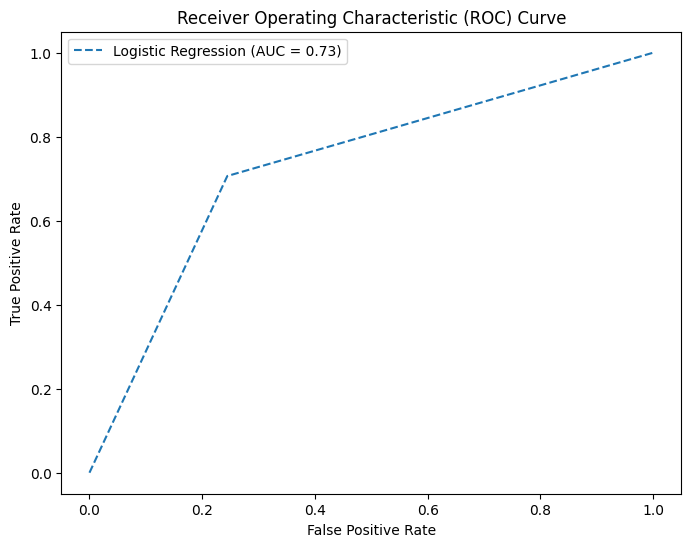

In [14]:
logistic_model = LogisticRegression()
logistic_model.fit(X_train_clean, y_train_clean)

# Make predictions on the test set
logistic_predictions = logistic_model.predict(X_test)

# Calculate AUC
logistic_auc = roc_auc_score(y_test, logistic_predictions)

# Generate ROC curve
fpr, tpr, _ = roc_curve(y_test, logistic_predictions)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, logistic_predictions)
print(f"Logistic Regression Accuracy: {accuracy:.2f}")
print("Logistic Regression Classification Report:")
print(classification_report(y_test, logistic_predictions))

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, linestyle='--', label='Logistic Regression (AUC = %0.2f)' % logistic_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

Decision Tree Classifier Accuracy: 0.83
Decision Tree Classifier Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.84      0.84     56701
           1       0.84      0.82      0.83     56853

    accuracy                           0.83    113554
   macro avg       0.83      0.83      0.83    113554
weighted avg       0.83      0.83      0.83    113554



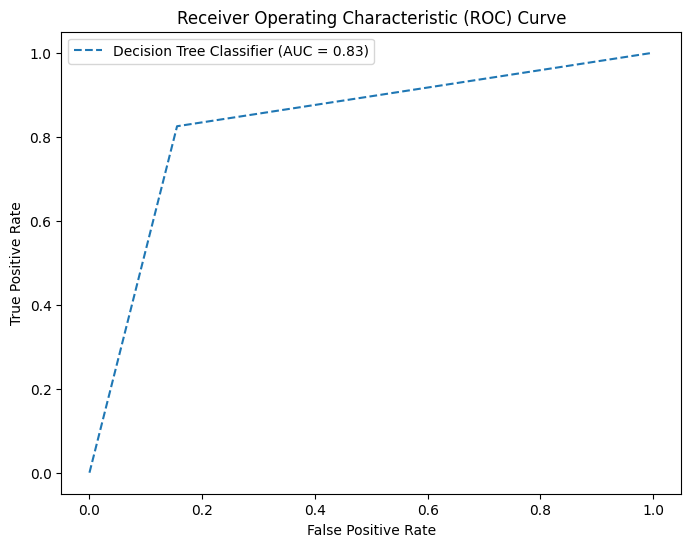

In [15]:
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train_clean, y_train_clean)

# Make predictions on the test set
dt_predictions = dt_model.predict(X_test)

# Calculate AUC
dt_auc = roc_auc_score(y_test, dt_predictions)

# Generate ROC curve
fpr, tpr, _ = roc_curve(y_test, dt_predictions)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, dt_predictions)
print(f"Decision Tree Classifier Accuracy: {accuracy:.2f}")
print("Decision Tree Classifier Classification Report:")
print(classification_report(y_test, dt_predictions))

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, linestyle='--', label='Decision Tree Classifier (AUC = %0.2f)' % dt_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

Random Forest Classifier Accuracy: 0.89
Random Forest Classifier Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.94      0.89     56701
           1       0.93      0.84      0.88     56853

    accuracy                           0.89    113554
   macro avg       0.89      0.89      0.89    113554
weighted avg       0.89      0.89      0.89    113554



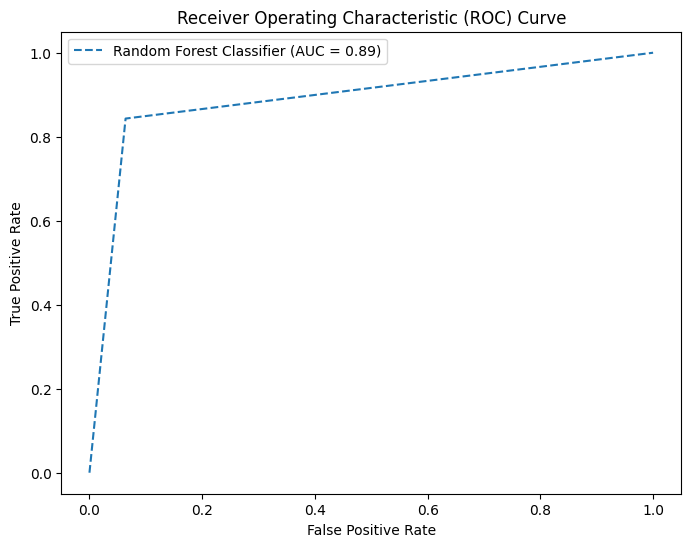

In [16]:
# Create and train the Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_clean, y_train_clean)

# Make predictions on the test set
rf_predictions = rf_model.predict(X_test)

# Calculate AUC
rf_auc = roc_auc_score(y_test, rf_predictions)

# Generate ROC curve
fpr, tpr, _ = roc_curve(y_test, rf_predictions)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, rf_predictions)
print(f"Random Forest Classifier Accuracy: {accuracy:.2f}")
print("Random Forest Classifier Classification Report:")
print(classification_report(y_test, rf_predictions))

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, linestyle='--', label='Random Forest Classifier (AUC = %0.2f)' % rf_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

Random Forest Classifier Accuracy: 0.92
Random Forest Classifier Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.94      0.92     56701
           1       0.94      0.90      0.92     56853

    accuracy                           0.92    113554
   macro avg       0.92      0.92      0.92    113554
weighted avg       0.92      0.92      0.92    113554



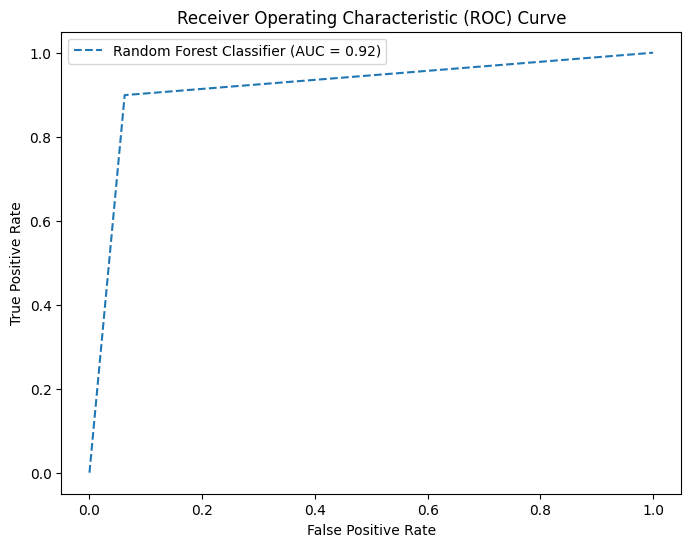

In [17]:
xgb_model = XGBClassifier(n_estimators = 400, learning_rate=0.1, max_depth=3)
xgb_model.fit(X_train_clean, y_train_clean)

xg_predictions = xgb_model.predict(X_test)

rf_auc = roc_auc_score(y_test, xg_predictions)

fpr, tpr, _ = roc_curve(y_test, xg_predictions)

accuracy = accuracy_score(y_test, xg_predictions)
print(f"Random Forest Classifier Accuracy: {accuracy:.2f}")
print("Random Forest Classifier Classification Report:")
print(classification_report(y_test, xg_predictions))

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, linestyle='--', label='Random Forest Classifier (AUC = %0.2f)' % rf_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

In [18]:
lgbm_model = LGBMClassifier(n_estimators = 400)
lgbm_model.fit(X_train_clean, y_train_clean)


lg_predictions = lgbm_model.predict(X_test)

lg_auc = roc_auc_score(y_test, lg_predictions)

fpr, tpr, _ = roc_curve(y_test, lg_predictions)

accuracy = accuracy_score(y_test, lg_predictions)
print(f"Random Forest Classifier Accuracy: {accuracy:.2f}")
print("Random Forest Classifier Classification Report:")
print(classification_report(y_test, lg_predictions))

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, linestyle='--', label='Random Forest Classifier (AUC = %0.2f)' % lg_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

SyntaxError: unmatched ')' (2317862768.py, line 2)